In [35]:
import sys;import os;
module_path = os.path.abspath(os.path.join('..')).split('PythonCode')[0]+'PythonCode'
if module_path not in sys.path: sys.path.append(module_path+"/")
    
import Plib.Futures.TermStructure as ts
import Plib.DataFarm.Norgate as ng
import Plib.Utils.Tools as tl

import datetime
import pandas as pd
import numpy as np

import shutup; shutup.please()

# Load Contract Data and Create Continous Future

In [12]:
sym='CL2'
trad_date='2022-04-22'
pr_label='Close'
dstart='1983-03-30'
dend='2022-04-22'

df=ng.getSingleFut(sym,freq='D')

#Define expiration rule
#expf = lambda x: tl.getNthWd(x,wd='friday',nth=3,bus_days=0,hformat=False)
#expf = lambda x: tl.getNhBD(x,start='first',bus_days=10,hformat=False)
#expf = lambda x: tl.getNthWd(x,wd='friday',nth=3,bus_days=1,hformat=False,month_shift=-1)
# CL expiration at 20 of previous month
expf = lambda x: tl.getNhBD(x,start=20,bus_days=0,hformat=False,month_shift=-1) 
df=df[df['Year']<'2025']

df=tl.getFutMonthsExp(df,expf=expf)
#For single contract evaluation
dfc2=df.copy()
df.tail(5)

Open   High    Low  Close  Adjusted_close  Volume  openInterest  \
Date                                                                           
1983-03-30  29.01  29.56  29.01  29.40           29.40     949           470   
1983-03-30  29.10  29.40  29.10  29.35           29.35     471           283   
1983-03-30  29.10  29.30  29.10  29.20           29.20     216           154   
1983-03-30  28.85  29.20  28.80  28.95           28.95     160            91   
1983-03-30  28.90  28.95  28.70  28.95           28.95      18            14   

           Month  Year  Dte  Expiration  
Date                                     
1983-03-30     M  1983   50  1983-05-19  
1983-03-30     N  1983   82  1983-06-20  
1983-03-30     Q  1983  112  1983-07-20  
1983-03-30     U  1983  141  1983-08-18  
1983-03-30     V  1983  174  1983-09-20

### Select Roll Method 

For backtesting purposes either 'panama-back-adj' or 'ratio-back-adj' are fine since both preserve percentages.
In some instances a calendar weighted (i.e., decreasing weight to older contract/increasing weight to newer contract) or volume/oi importance (i.e., defining roll date as the day in which Vol/oi of older contract becomes less than the newer contract) approach can be used. Also interest rate adjusted (i.e., new_close = 1- (exp_days/360)*Fed_rate)) roll method can be employed for specific products.

In [13]:
dfc=ts.createContFut(df,trading_date=trad_date, label=pr_label, method='panama-back-adj')
dfc.head(5)

Open   High    Low  Close  Adjusted_close  Volume  openInterest  \
Date                                                                           
2022-02-22  91.75  96.00  90.35  92.35           92.35   40745          2639   
2022-02-18  91.63  92.66  89.03  91.07           91.07  150382         28199   
2022-02-17  90.90  93.36  90.62  91.76           91.76  212552         73639   
2022-02-16  92.21  95.01  90.00  93.66           93.66  401453        103461   
2022-02-15  94.83  95.17  90.66  92.07           92.07  442641        155289   

           Month  Year  Dte  
Date                         
2022-02-22     H  2022 -1.0  
2022-02-18     H  2022  3.0  
2022-02-17     H  2022  4.0  
2022-02-16     H  2022  5.0  
2022-02-15     H  2022  6.0

### Plot Term Structure from Trading Date

By looking at future expirations in a given trading date we can infer whether the future curve is in backwardation (i.e., decreasing prices) or in contango (i.e., increasing prices). If we assume today prices as static, with backwardation the next expirations must increase in price to equilibrate with current prices; at the opposite, with contango next expirations must decrease.

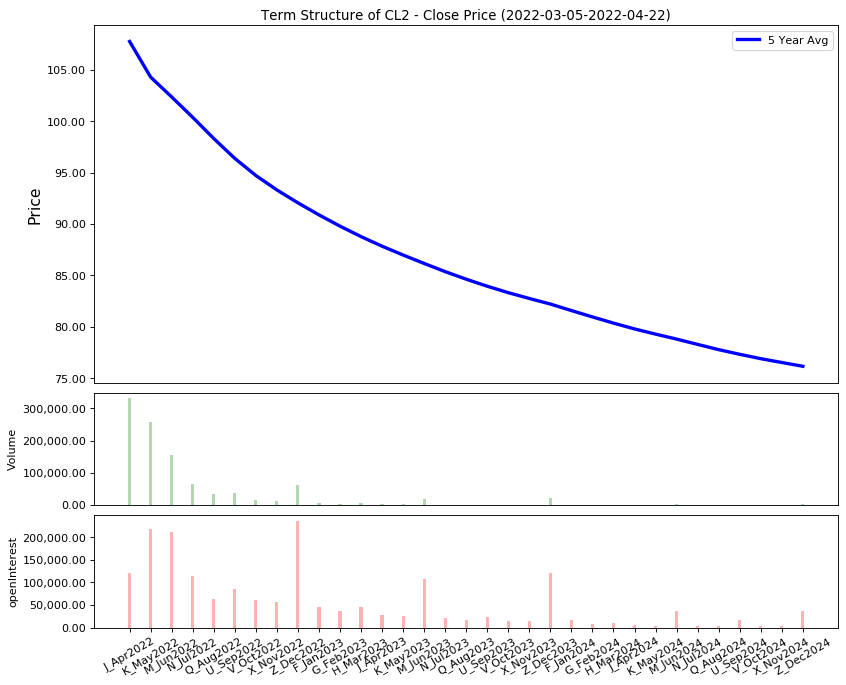

In [14]:
pvt,avgp,avgv,avgoi=ts.mk_termStruct(df,trading_date=trad_date,lbl1=pr_label,lbl2='Volume',lbl3='openInterest',idx='Month',col='Year')    
ts.plotSeasonTermStruc(sym,pvt,avgp,avgv,avgoi,dt_start=trad_date,dt_end=dend,
                    lbl_tit=pr_label + ' Price',lbl_y='Price', plsrs=False)
#tl.display_side_by_side(pvt,avgp,avgv,avgoi)


### Implied Yield of Product 

By looking at the Implied Yield of next epirations it is possible to compare different futures contract on the same basis to decide which is more profitable to trade; often, a fixed threshold of k% is used as a rule: 
IY > k%  -> buy 
IY < -k% -> sell 

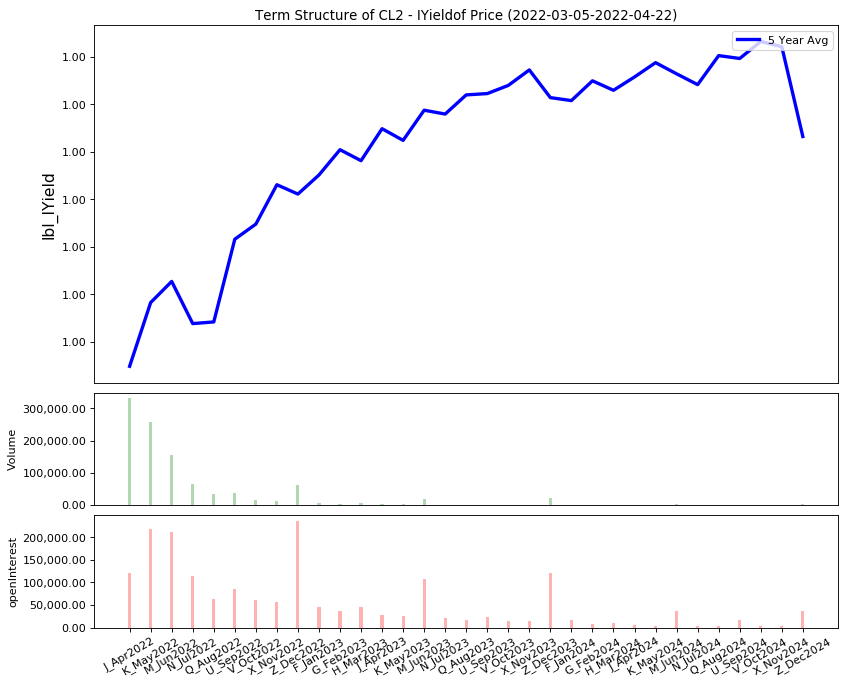

In [15]:
lbl_IYield='IYield'
df=ts.getImpliedYield(df,lbl_price=pr_label)
pvt,avgp,avgv,avgoi=ts.mk_termStruct(df,trading_date=trad_date,lbl1=lbl_IYield,lbl2='Volume',lbl3='openInterest',idx='Month',col='Year')    
ts.plotSeasonTermStruc(sym,pvt,avgp,avgv,avgoi,dt_start=trad_date,dt_end=dend,
                    lbl_tit=lbl_IYield + 'of Price',lbl_y='lbl_IYield', plsrs=False)
#tl.display_side_by_side(pvt,avgp,avgv,avgoi)


### Historical Term Structure of Prices

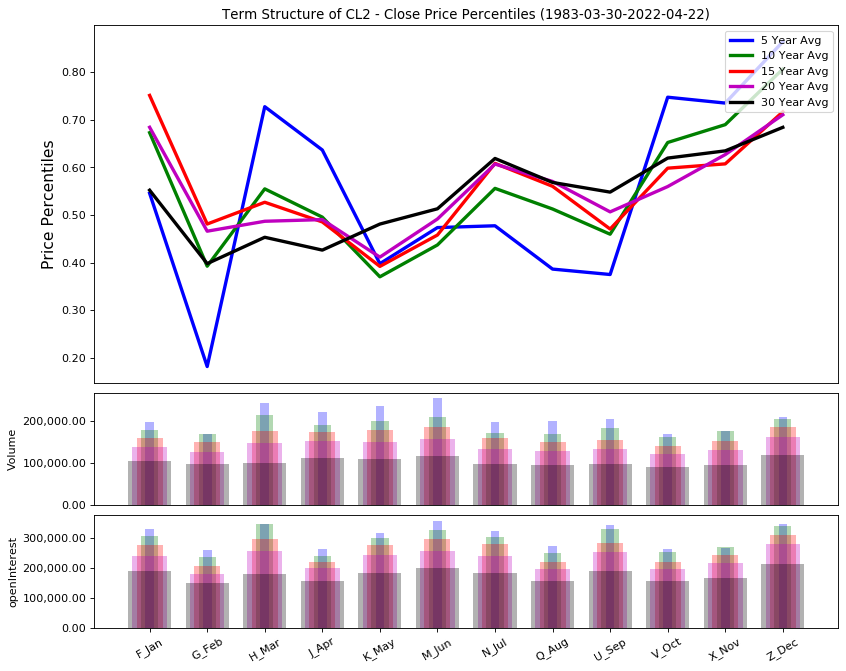

In [16]:
pvt,avgp,avgv,avgoi=ts.mk_seasonalAvg(dfc,lbl1=pr_label,lbl2='Volume',lbl3='openInterest',idx='Month',col='Year',perc=True) 
ts.plotSeasonTermStruc(sym,pvt,avgp,avgv,avgoi,dt_start=dstart,dt_end=dend,
                    lbl_tit=pr_label + ' Price Percentiles',lbl_y='Price Percentiles', plsrs=False)
#tl.display_side_by_side(pvt,avgp,avgv,avgoi)


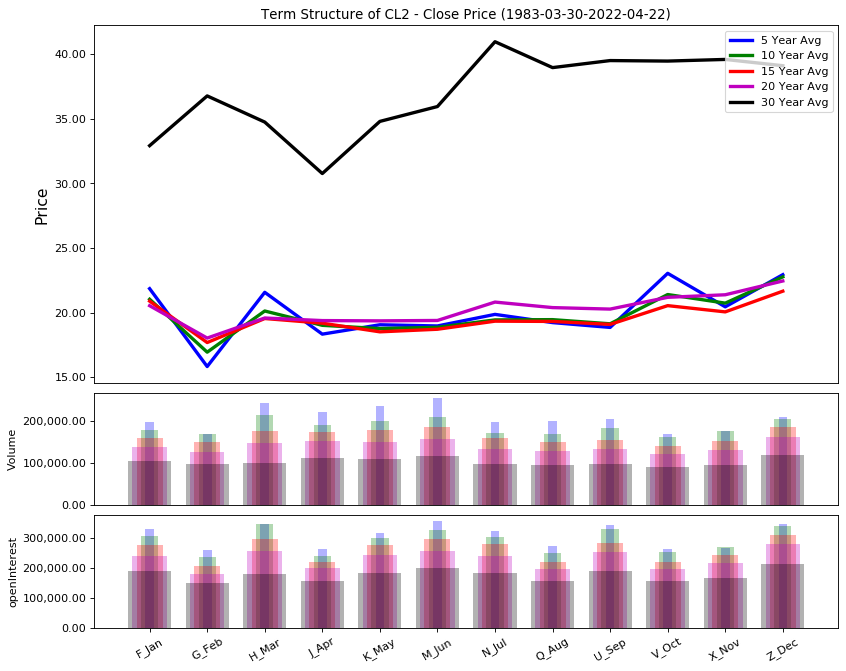

In [17]:
pvt,avgp,avgv,avgoi=ts.mk_seasonalAvg(dfc,lbl1=pr_label,lbl2='Volume',lbl3='openInterest',idx='Month',col='Year') 
ts.plotSeasonTermStruc(sym,pvt,avgp,avgv,avgoi,dt_start=dstart,dt_end=dend,
                    lbl_tit=pr_label + ' Price',lbl_y='Price', plsrs=False)
#tl.display_side_by_side(pvt,avgp,avgv,avgoi)


### Historical Term Structure of Returns

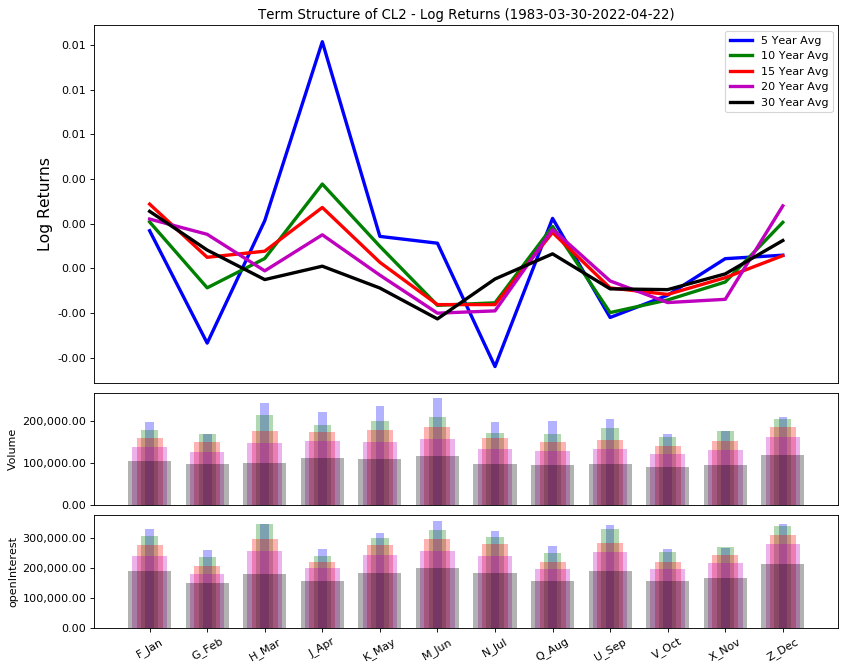

In [18]:
ret_label='Returns'
dfc=ts.getLogReturns(dfc,ret_label=ret_label,pr_label=pr_label)
pvt,avgp,avgv,avgoi=ts.mk_seasonalAvg(dfc,lbl1=ret_label,lbl2='Volume',lbl3='openInterest',idx='Month',col='Year')    
ts.plotSeasonTermStruc(sym,pvt,avgp,avgv,avgoi,dt_start=dstart,dt_end=dend,
                    lbl_tit='Log Returns',lbl_y='Log Returns', plsrs=False)
#tl.display_side_by_side(pvt,avgp,avgv,avgoi)


### Historical Term Structure of Skew

The Skew of returns can be used to decide to trade: low skew -> buy whereas high skew -> sell

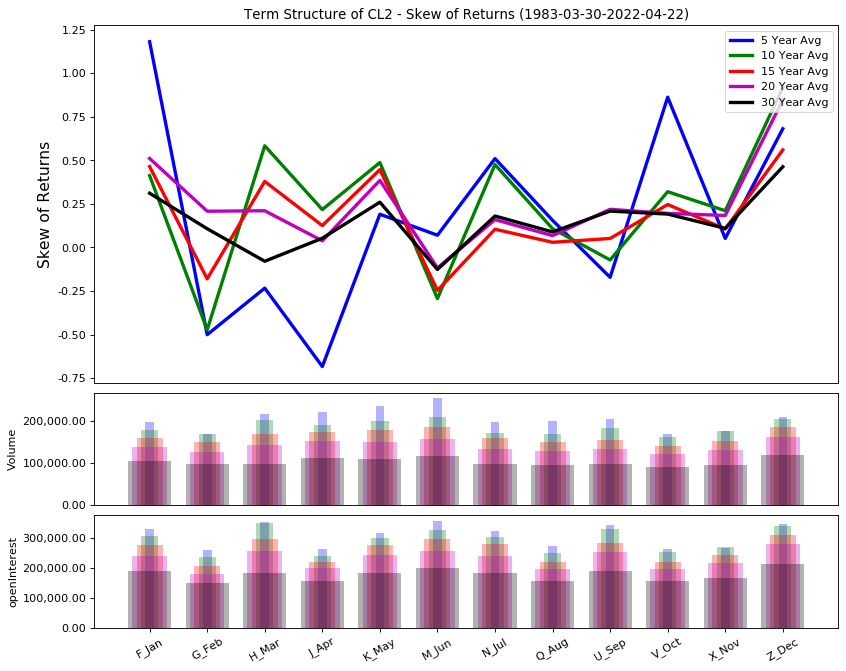

In [19]:
roll_window=20
dfc=ts.df_rolling_skew(dfc,lbl_rets=ret_label,roll_win=roll_window)
skew_label='Skew-'+str(roll_window)
pvt,avgp,avgv,avgoi=ts.mk_seasonalAvg(dfc,lbl1=skew_label,lbl2='Volume',lbl3='openInterest',idx='Month',col='Year')    
ts.plotSeasonTermStruc(sym,pvt,avgp,avgv,avgoi,dt_start=dstart,dt_end=dend,
                    lbl_tit='Skew of Returns',lbl_y='Skew of Returns', plsrs=False)
#tl.display_side_by_side(pvt,avgp,avgv,avgoi)


# Analizing Volatility

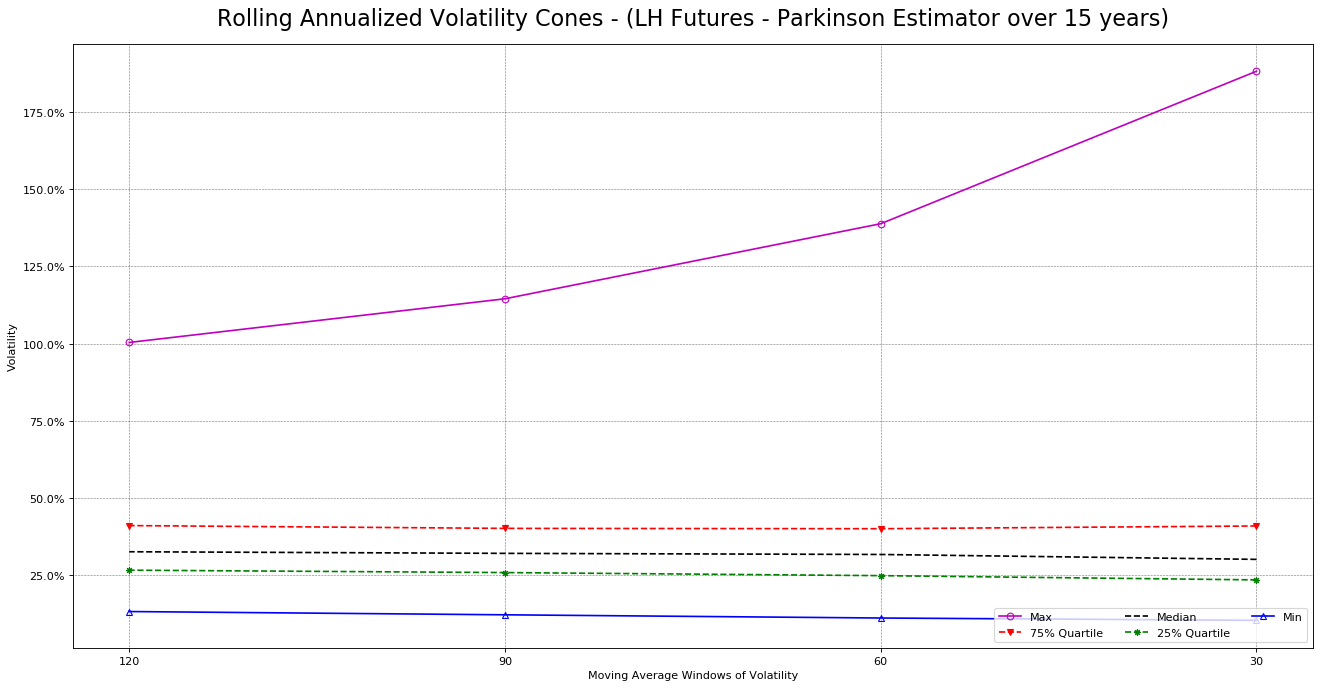

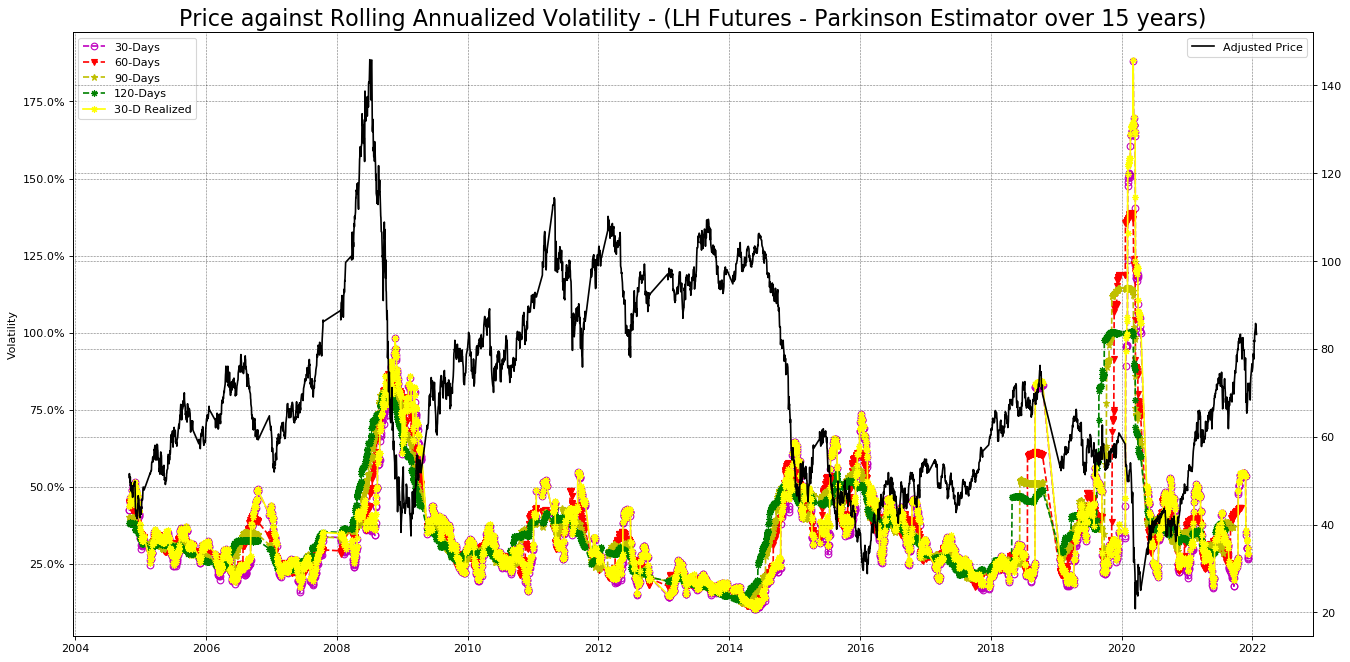

Current Price and Estimated std: 50.74 0.0593
Price Range in one standard deviation: 53.7489 47.7311


In [20]:
ret=ts.volFutures(dfc,symbol='LH', years=15)

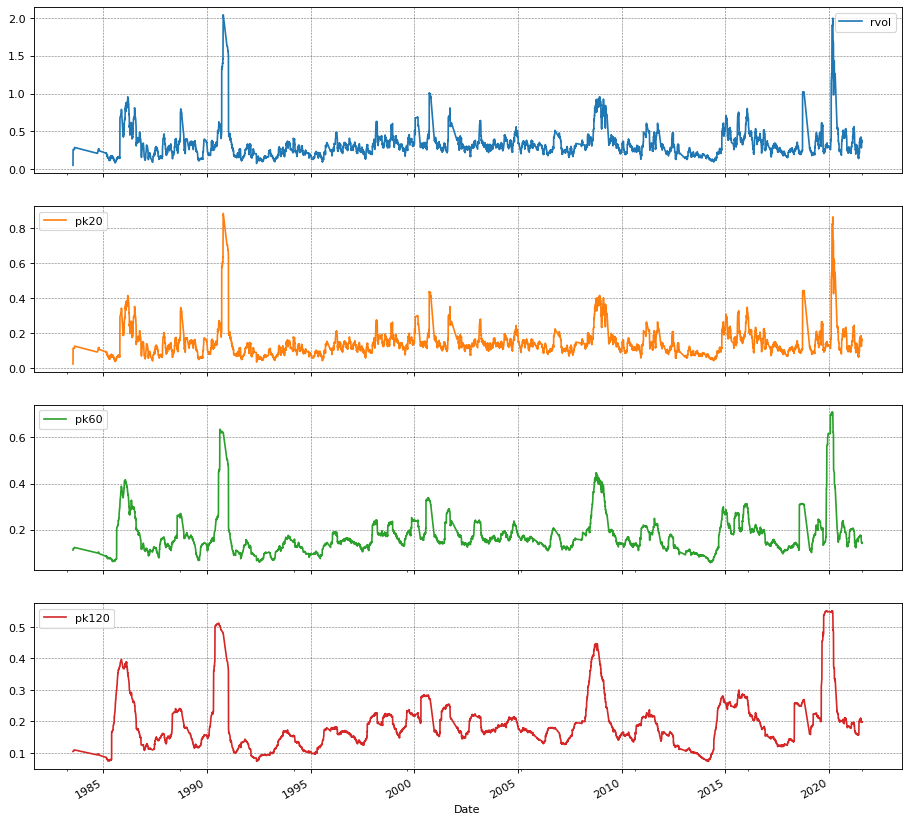

In [21]:
rvol, pk_20, pk_60, pk_120 = ts.getFutVols(dfc, years=51)
dfc=ts.plotFutVols(dfc,rvol, pk_20, pk_60, pk_120)


### Historical Term Structure of Volatility

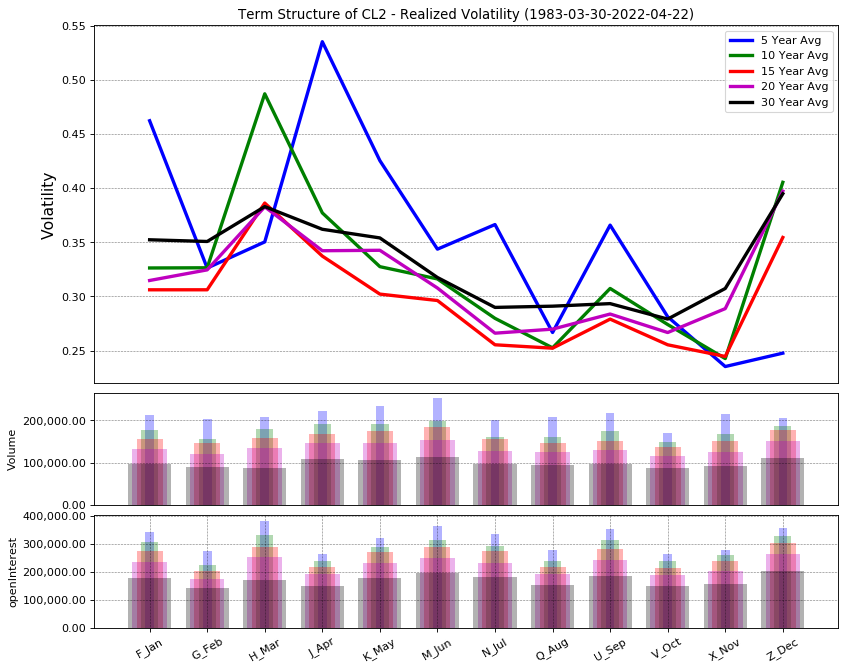

In [22]:
vol_label='rvol'
vol_desc='Realized'

pvt,avgp,avgv,avgoi=ts.mk_seasonalAvg(dfc,lbl1=vol_label,lbl2='Volume',lbl3='openInterest',idx='Month',col='Year')    
ts.plotSeasonTermStruc(sym,pvt,avgp,avgv,avgoi,dt_start=dstart,dt_end=dend,
                    lbl_tit=vol_desc+' Volatility',lbl_y='Volatility', plsrs=False)
#tl.display_side_by_side(pvt,avgp,avgv,avgoi)


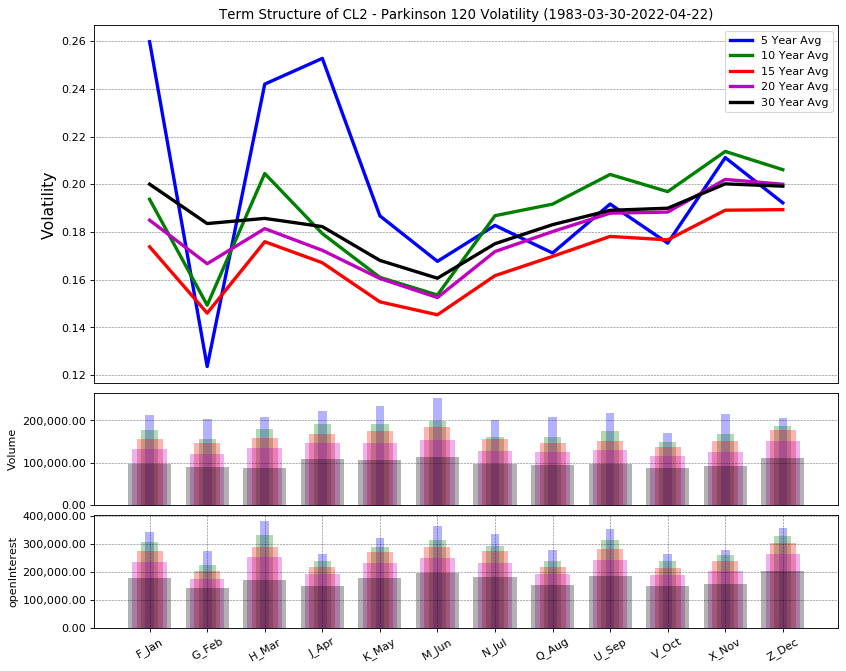

In [23]:
vol_label='pk120'
vol_desc='Parkinson 120'

pvt,avgp,avgv,avgoi=ts.mk_seasonalAvg(dfc,lbl1=vol_label,lbl2='Volume',lbl3='openInterest',idx='Month',col='Year')    
ts.plotSeasonTermStruc(sym,pvt,avgp,avgv,avgoi,dt_start=dstart,dt_end=dend,
                    lbl_tit=vol_desc+' Volatility',lbl_y='Volatility', plsrs=False)
#tl.display_side_by_side(pvt,avgp,avgv,avgoi)


# Consider Single Contract Seasonality 

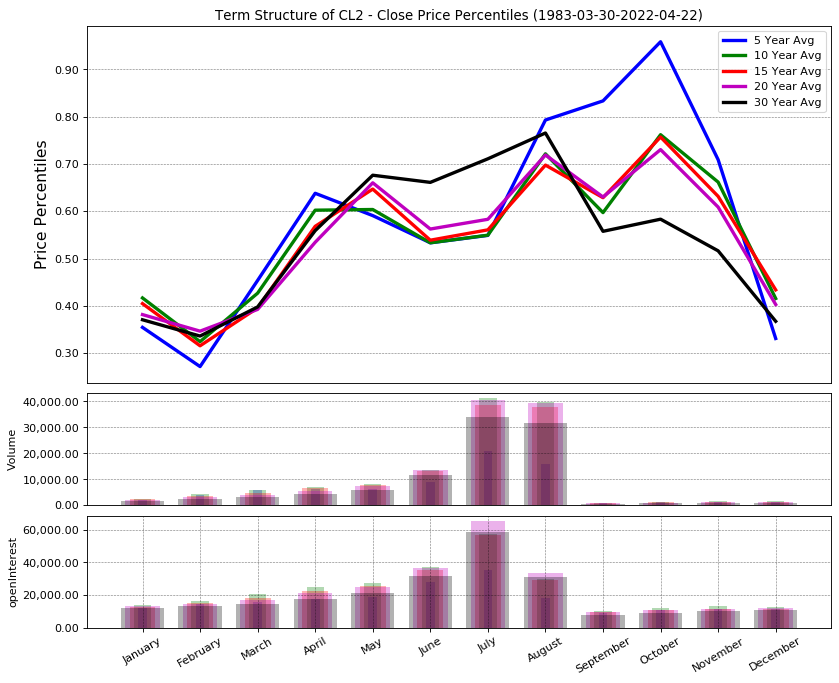

In [24]:
lbl_month='U'
dfcS=dfc2[(dfc2['Month']==lbl_month)].copy()
dfcS['Month2']=dfcS.index.month_name()

pvt,avgp,avgv,avgoi=ts.mk_seasonalAvg(dfcS,lbl1=pr_label,lbl2='Volume',lbl3='openInterest',idx='Month2',col='Year',perc=True) 
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
pvt=pvt.reindex(new_order, axis=0)
avgp=avgp.reindex(new_order, axis=0)
avgv=avgv.reindex(new_order, axis=0)
avgoi=avgoi.reindex(new_order, axis=0)
ts.plotSeasonTermStruc(sym,pvt,avgp,avgv,avgoi,dt_start=dstart,dt_end=dend,
                    lbl_tit=pr_label + ' Price Percentiles',lbl_y='Price Percentiles', plsrs=False)
#tl.display_side_by_side(pvt,avgp,avgv,avgoi)


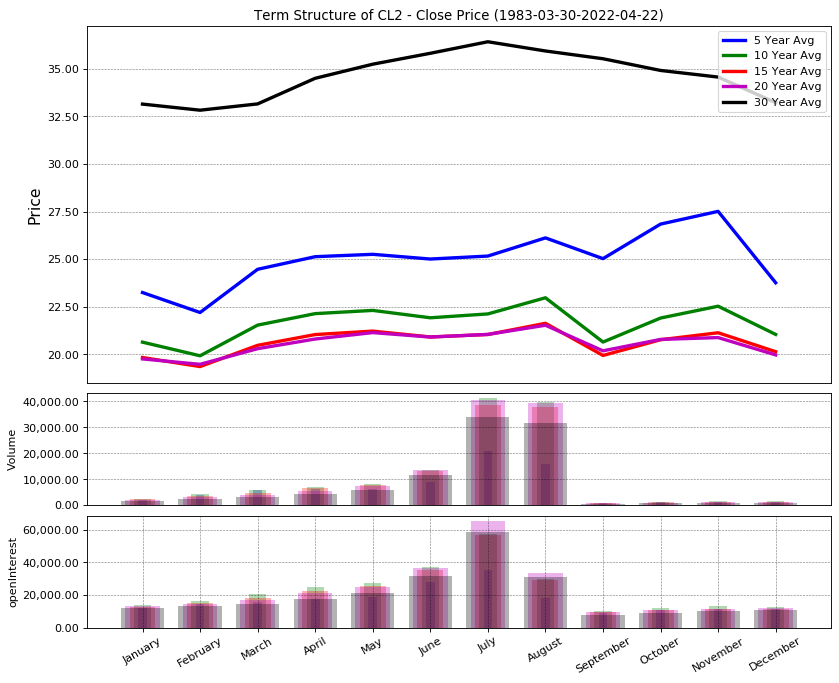

In [25]:
pvt,avgp,avgv,avgoi=ts.mk_seasonalAvg(dfcS,lbl1=pr_label,lbl2='Volume',lbl3='openInterest',idx='Month2',col='Year') 
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
pvt=pvt.reindex(new_order, axis=0)
avgp=avgp.reindex(new_order, axis=0)
avgv=avgv.reindex(new_order, axis=0)
avgoi=avgoi.reindex(new_order, axis=0)
ts.plotSeasonTermStruc(sym,pvt,avgp,avgv,avgoi,dt_start=dstart,dt_end=dend,
                    lbl_tit=pr_label + ' Price',lbl_y='Price', plsrs=False)
#tl.display_side_by_side(pvt,avgp,avgv,avgoi)


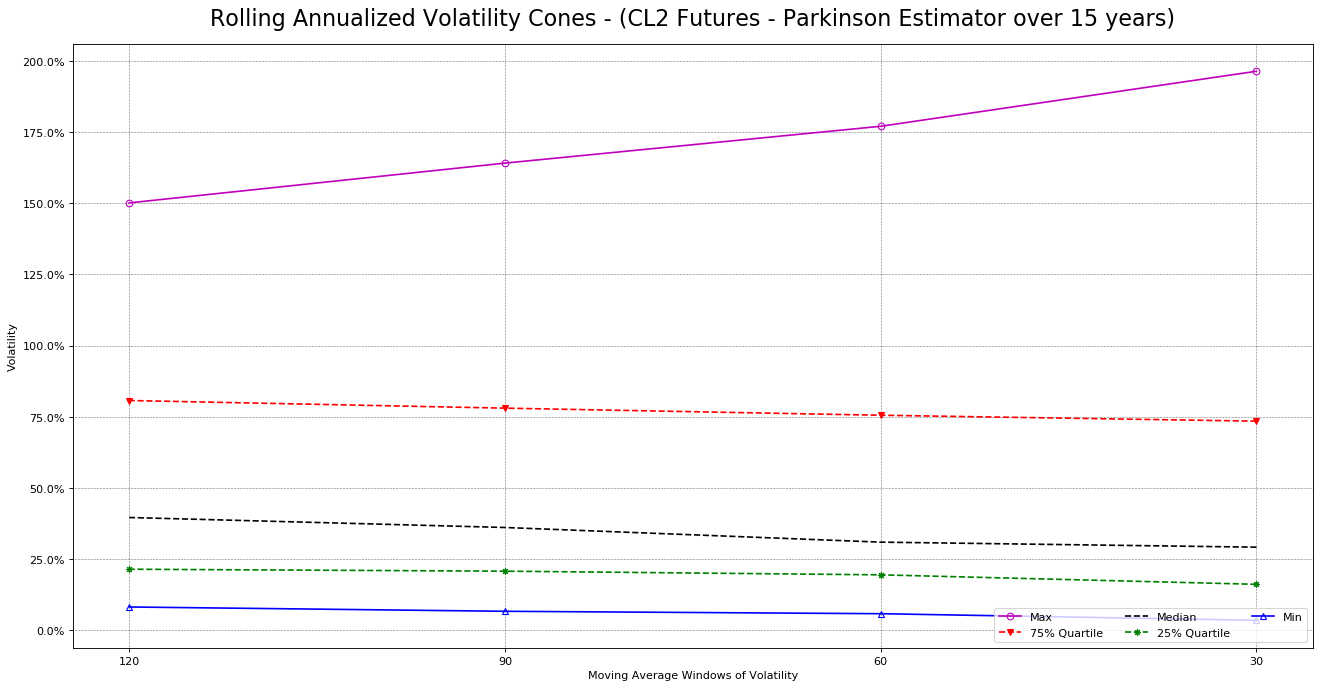

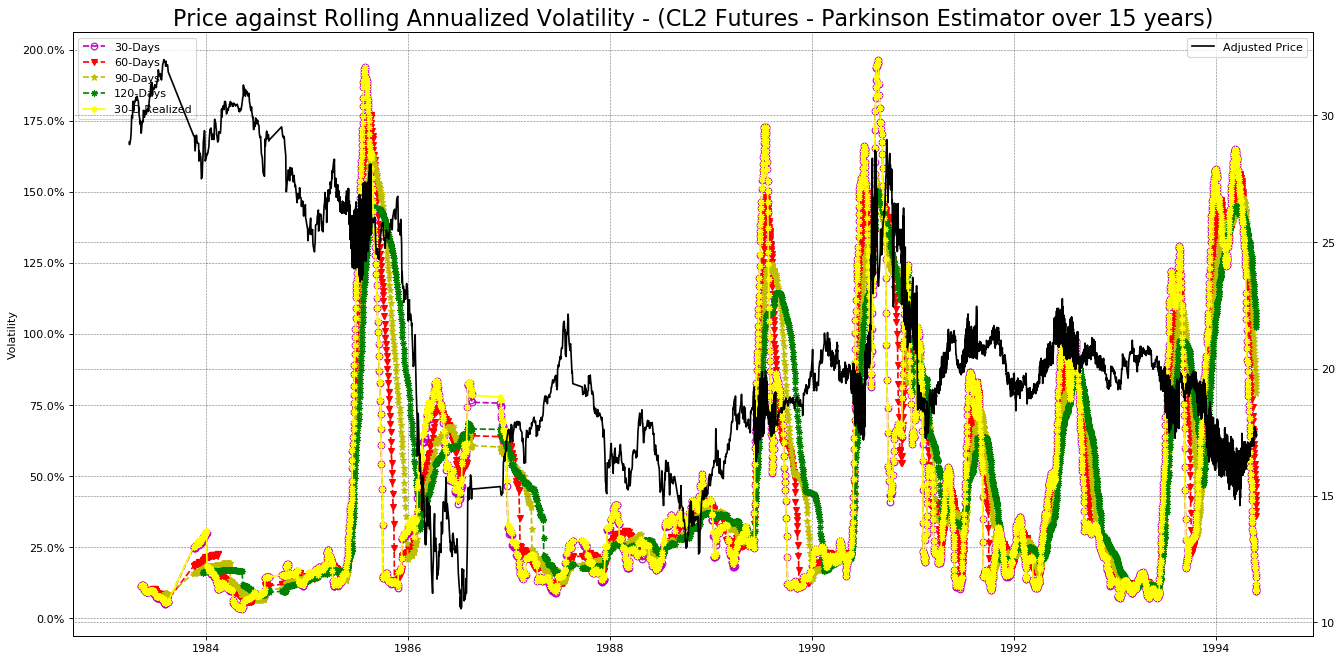

Current Price and Estimated std: 17.52 0.0705
Price Range in one standard deviation: 18.7552 16.2848


In [26]:
ret=ts.volFutures(dfcS,symbol='CL2', years=15)

### Spread

In [27]:
bmonth=lbl_month #'U'
fmonth=ts.getNextMonth(lbl_month,dfc)
#fmonth=getNextMonth(getNextMonth(lbl_month,dfc),dfc)


dfcL1=dfc2[(dfc2['Month']==bmonth)]
dfcL1['Month2']=dfcL1.index.month_name()

dfcL2=dfc2[(dfc2['Month']==fmonth)]
dfcL2['Month2']=dfcL2.index.month_name()

lbl_spread=' SPREAD ' + bmonth + '-' + fmonth + '/' + ts.getMonthLbl(bmonth) + '-' + ts.getMonthLbl(fmonth)  #'/Febr-Apr '

dfcSpread = pd.merge(dfcL1, dfcL2, left_index=True, right_index=True)
for lbl in ['Open','High','Low','Close','Adjusted_close']:
    dfcSpread[lbl+'_x']=dfcSpread[lbl+'_x'] - dfcSpread[lbl+'_y']
for lbl in ['Volume','openInterest']:
    dfcSpread[lbl+'_x']=dfcSpread[lbl+'_x'] + dfcSpread[lbl+'_y']

dfcSpread=dfcSpread[['Open_x', 'High_x', 'Low_x', 'Close_x', 'Adjusted_close_x', 'Volume_x',
       'openInterest_x', 'Month_x', 'Year_x', 'Dte_x', 'Expiration_x',
       'Month2_x']]
dfcSpread.columns=['Open', 'High', 'Low', 'Close', 'Adjusted_close', 'Volume',
       'openInterest', 'Month', 'Year', 'Dte', 'Expiration',
       'Month2']


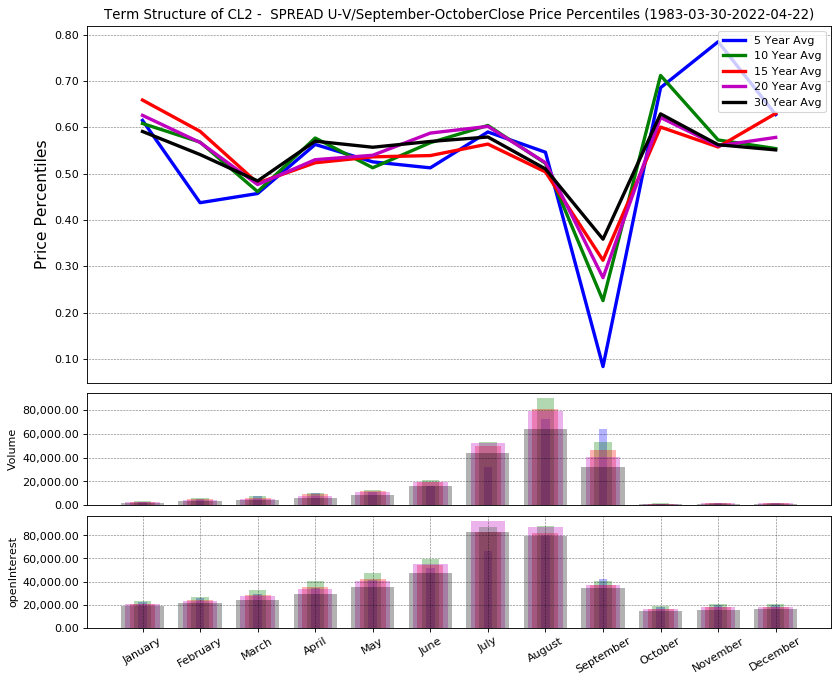

In [28]:
pvt,avgp,avgv,avgoi=ts.mk_seasonalAvg(dfcSpread,lbl1=pr_label,lbl2='Volume',lbl3='openInterest',idx='Month2',col='Year',perc=True) 
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
pvt=pvt.reindex(new_order, axis=0)
avgp=avgp.reindex(new_order, axis=0)
avgv=avgv.reindex(new_order, axis=0)
avgoi=avgoi.reindex(new_order, axis=0)
ts.plotSeasonTermStruc(sym,pvt,avgp,avgv,avgoi,dt_start=dstart,dt_end=dend,
                    lbl_tit=lbl_spread + pr_label + ' Price Percentiles',lbl_y='Price Percentiles', plsrs=False)
#tl.display_side_by_side(pvt,avgp,avgv,avgoi)


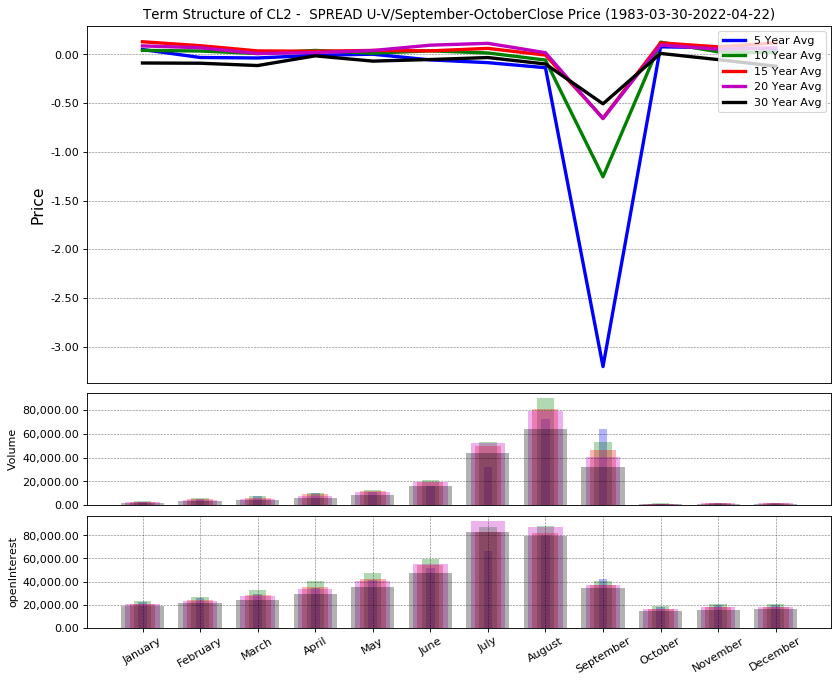

In [29]:
pvt,avgp,avgv,avgoi=ts.mk_seasonalAvg(dfcSpread,lbl1=pr_label,lbl2='Volume',lbl3='openInterest',idx='Month2',col='Year') 
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
pvt=pvt.reindex(new_order, axis=0)
avgp=avgp.reindex(new_order, axis=0)
avgv=avgv.reindex(new_order, axis=0)
avgoi=avgoi.reindex(new_order, axis=0)
ts.plotSeasonTermStruc(sym,pvt,avgp,avgv,avgoi,dt_start=dstart,dt_end=dend,
                    lbl_tit=lbl_spread+pr_label + ' Price',lbl_y='Price', plsrs=False)
#tl.display_side_by_side(pvt,avgp,avgv,avgoi)


# Weekly Plots

No handles with labels found to put in legend.


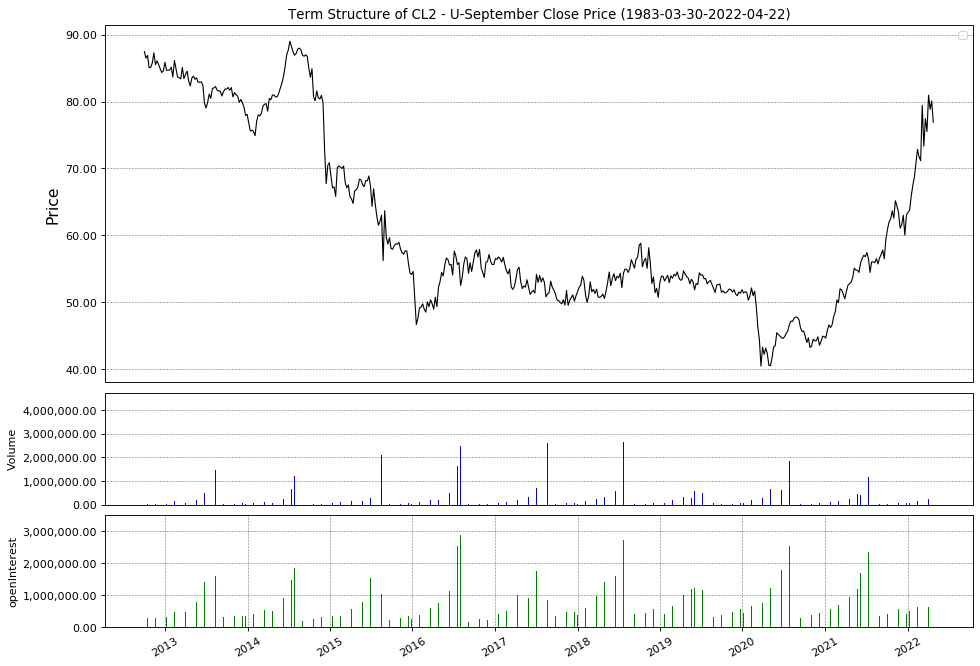

In [30]:
lbl_wc=bmonth+'-'+ts.getMonthLbl(bmonth)

ts.plotWeeklyCont(sym, dfcL1, lbl_plot1=pr_label,lbl_plot2='Volume',lbl_plot3='openInterest', 
               dt_start=str(dfcL1.index.min())[:10],dt_end=str(dfcL1.index.max())[:10],
               lbl_tit=lbl_wc +' '+ pr_label + ' Price',lbl_y='Price')


No handles with labels found to put in legend.


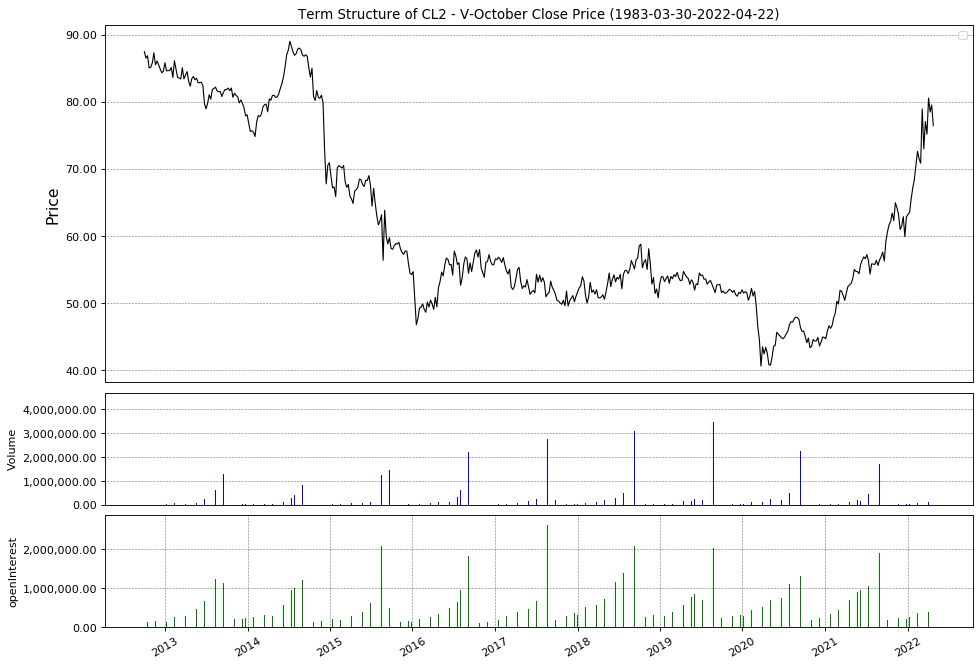

In [31]:
lbl_wc=fmonth+'-'+ts.getMonthLbl(fmonth)

ts.plotWeeklyCont(sym, dfcL2, lbl_plot1=pr_label,lbl_plot2='Volume',lbl_plot3='openInterest', 
               dt_start=str(dfcL2.index.min())[:10],dt_end=str(dfcL2.index.max())[:10],
               lbl_tit=lbl_wc + ' ' + pr_label + ' Price',lbl_y='Price')


No handles with labels found to put in legend.


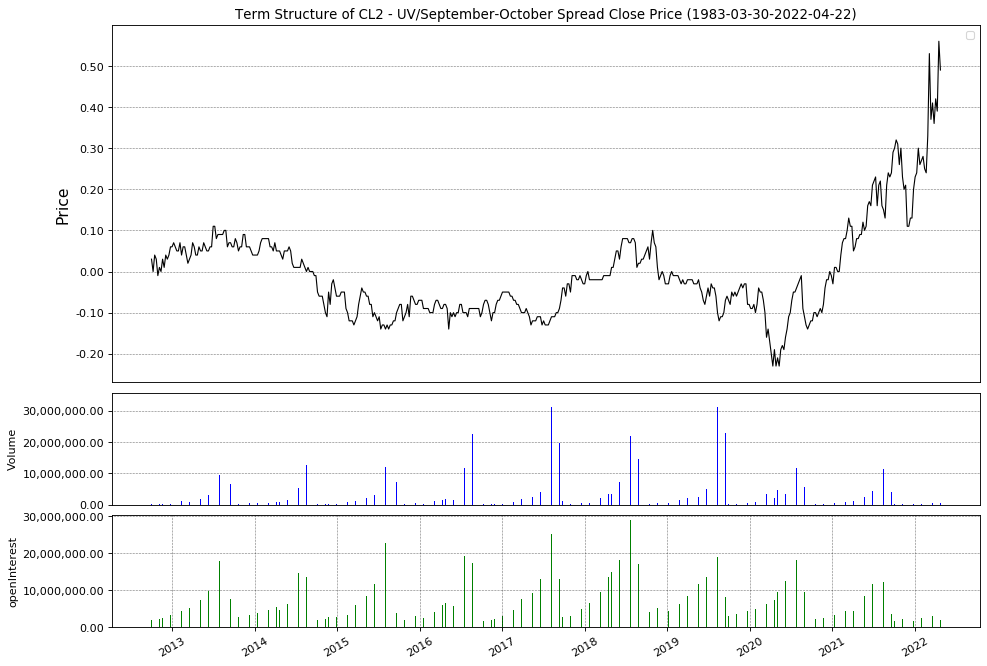

In [32]:
lbl_wc=bmonth+fmonth+'/'+ts.getMonthLbl(bmonth)+'-'+ts.getMonthLbl(fmonth) + ' Spread'

ts.plotWeeklyCont(sym, dfcSpread, lbl_plot1=pr_label,lbl_plot2='Volume',lbl_plot3='openInterest', 
               dt_start=str(dfcSpread.index.min())[:10],dt_end=str(dfcSpread.index.max())[:10],
               lbl_tit=lbl_wc+ ' '+ pr_label+' Price',lbl_y='Price')


No handles with labels found to put in legend.


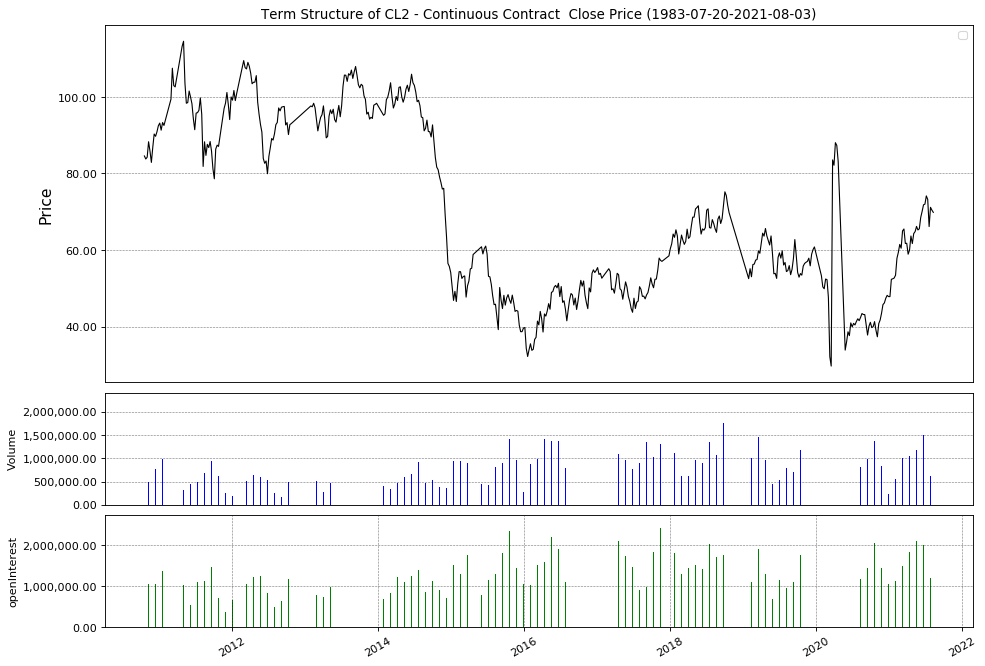

In [33]:
lbl_wc='Continuous Contract '

ts.plotWeeklyCont(sym, dfc, lbl_plot1=pr_label,lbl_plot2='Volume',lbl_plot3='openInterest', 
               dt_start=str(dfc.index.min())[:10],dt_end=str(dfc.index.max())[:10],
               lbl_tit=lbl_wc+' '+pr_label + ' Price',lbl_y='Price')


# Monthly Plots

No handles with labels found to put in legend.


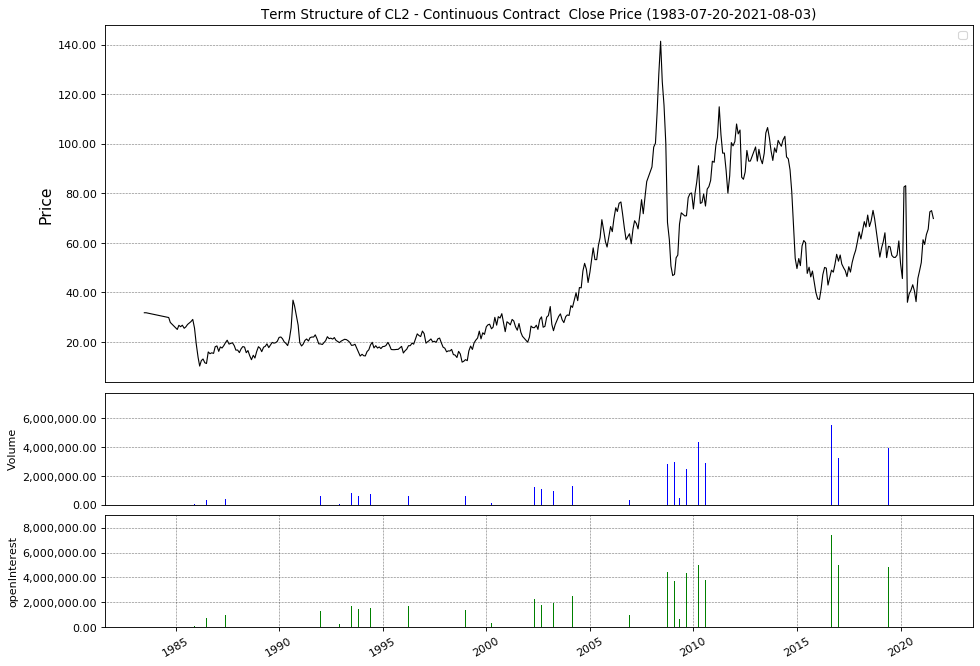

In [34]:
lbl_wc='Continuous Contract '

ts.plotMonthlyCont(sym, dfc, lbl_plot1=pr_label,lbl_plot2='Volume',lbl_plot3='openInterest', 
               dt_start=str(dfc.index.min())[:10],dt_end=str(dfc.index.max())[:10],
               lbl_tit=lbl_wc+' '+pr_label + ' Price',lbl_y='Price')

